In [18]:
# Basic lib imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import collections
from scipy import stats
import seaborn as sns
import pickle
%matplotlib inline

In [7]:
# Data imports
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/'
#adnimerge_file = 'ADNIMERGE.csv'
hc_vol_file = '/input_csv/adni2-qcvols_nodups.csv'
CT_file = 'input_csv/ADNI2_subject_ROI_CT_dict_AAL.csv'
hc_data = pd.read_csv(baseline_dir + hc_vol_file)
ct_data = pd.read_csv(baseline_dir + CT_file)
#print ct_data.columns

In [3]:
#HC + CT Merge
in_data = pd.merge(hc_data, ct_data, on='ImageUID',how='inner')
#in_data.to_csv(baseline_dir + 'adni2-qcvols_nodups_aal_ct.csv'

In [22]:
#ADNI1 vs. ADNI2 common PTIDs
# baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/'
# adnimerge_file = 'input_csv/ADNIMERGE.csv'
# adnimerge_df = pd.read_csv(baseline_dir + adnimerge_file)
# adni1_ptids = adnimerge_df[adnimerge_df.ORIGPROT == 'ADNI1']['PTID'].values
# adni2_ptids = adnimerge_df[adnimerge_df.ORIGPROT == 'ADNI2']['PTID'].values
#Load from pkls
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/'
ADNI1_data_path = baseline_dir + 'CS/ADNI1_BL_PTID_ADAS13_dict.pkl'
ADNI2_data_path = baseline_dir + 'CS/ADNI2_BL_PTID_ADAS13_dict.pkl'

adni1_ptids = pickle.load( open(ADNI1_data_path, "rb" ) ).keys()
adni2_ptids = pickle.load( open(ADNI2_data_path, "rb" ) ).keys()

print len(adni1_ptids)
print len(adni2_ptids)

adni1_sub_idx = []
adni2_sub_idx = []
for i in list(adni1_ptids):
    adni1_sub_idx.append(i.split('_')[0])
for i in list(adni2_ptids):
    adni2_sub_idx.append(i.split('_')[0])

#print adni1_sub_idx, adni2_sub_idx
adni1_and_2_common_subs = set(adni1_sub_idx).intersection(adni2_sub_idx)
print adni1_and_2_common_subs
print len(adni1_and_2_common_subs)

#Common subject IDs after filtering out through modalities (51 total common between ADNI1(690) and ADNI2(669))
#set(['072', '073', '022', '094', '130', '032', '012', '013', '137', '016', '018', '033', '031', '036', '100', '014', 
#'035', '057', '037', '116', '052', '068', '053', '067', '141', '082', '003', '002', '027', '123', '021', '006', '005', 
#'127', '128', '129', '009', '029', '024', '041', '010', '011', '023', '131', '941', '109', '051', '114', '007', '126', '020'])

819
789
set(['098', '099', '072', '126', '022', '094', '130', '011', '012', '013', '137', '136', '016', '018', '033', '057', '036', '100', '014', '035', '031', '037', '116', '052', '068', '032', '053', '067', '141', '073', '082', '003', '002', '027', '123', '007', '006', '005', '127', '128', '129', '009', '029', '041', '010', '024', '023', '131', '941', '109', '051', '114', '021', '020'])
54


In [4]:
# Extract subset of columns and subjects (cohort)
cohort = 'ADNI2'
#demographics
col_list_demo = ['PTID','ImageUID','AGE','PTGENDER','APOE4']
data_demo  = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'bl')][col_list_demo]

#add a column with numerical DX mapping
# set(['MCI to NL', 'Dementia', 'NL', 'MCI'])
# set(['Dementia', 'NL', 'NL to MCI', 'MCI', 'MCI to Dementia', 'MCI to NL'])
# set(['Dementia', 'NL', 'NL to MCI', 'MCI', 'MCI to Dementia', 'MCI to NL'])
# set([nan, 'Dementia', 'NL', 'NL to MCI', 'MCI', 'Dementia to MCI', 'MCI to Dementia', 'MCI to NL'])
in_data['DX_cat'] = in_data['DX'].replace(['MCI to NL', 'NL'], 0)
in_data['DX_cat'] = in_data['DX_cat'].replace(['NL to MCI', 'MCI', 'Dementia to MCI'], 1)
in_data['DX_cat'] = in_data['DX_cat'].replace(['NL to Dementia','MCI to Dementia', 'Dementia'], 2)
in_data['DX_cat'].values.astype(float)

# features / variables
clinical_feat = ['PTID','DX','DX_cat','ADAS13','MMSE']
hc_feat = ['L_CA1','L_subiculum','L_CA4DG','L_CA2CA3','L_stratum','L_Alv','L_Fimb','L_Fornix','L_Mam',
                 'R_CA1','R_subiculum','R_CA4DG','R_CA2CA3','R_stratum','R_Alv','R_Fimb','R_Fornix','R_Mam']
ct_feat = ['AAL_1', 'AAL_2', 'AAL_3','AAL_4', 'AAL_5', 'AAL_6', 'AAL_7', 'AAL_8', 'AAL_9', 'AAL_10',
                 'AAL_11', 'AAL_12', 'AAL_13', 'AAL_14', 'AAL_15', 'AAL_16', 'AAL_17', 'AAL_18', 'AAL_19', 'AAL_20', 
                 'AAL_21', 'AAL_22', 'AAL_23', 'AAL_24', 'AAL_25', 'AAL_26', 'AAL_27', 'AAL_28', 'AAL_29', 'AAL_30', 
                 'AAL_31', 'AAL_32', 'AAL_33', 'AAL_34', 'AAL_35', 'AAL_36', 'AAL_39', 'AAL_40', 'AAL_43', 'AAL_44', 
                 'AAL_45', 'AAL_46', 'AAL_47', 'AAL_48', 'AAL_49', 'AAL_50', 'AAL_51', 'AAL_52', 'AAL_53', 'AAL_54',
                 'AAL_55', 'AAL_56', 'AAL_57', 'AAL_58', 'AAL_59', 'AAL_60', 'AAL_61', 'AAL_62', 'AAL_63', 'AAL_64', 
                 'AAL_65', 'AAL_66', 'AAL_67', 'AAL_68', 'AAL_69', 'AAL_70', 'AAL_79', 'AAL_80', 'AAL_81', 'AAL_82',
                 'AAL_83', 'AAL_84', 'AAL_85', 'AAL_86', 'AAL_87', 'AAL_88', 'AAL_89', 'AAL_90']

col_list_feat = clinical_feat + hc_feat + ct_feat

data_bl  = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'bl')][col_list_feat]
#data_bl = data_bl.drop_duplicates(subset='PTID', keep='first')
data_m03 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm03')][col_list_feat]
#data_m03 = data_m03.drop_duplicates(subset='PTID', keep='first')
data_m06 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm06')][col_list_feat]
#data_m06 = data_m06.drop_duplicates(subset='PTID', keep='first')
data_m12 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm12')][col_list_feat]
#data_m12 = data_m12.drop_duplicates(subset='PTID', keep='first')
data_m24 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm24')][col_list_feat]
#data_m24 = data_m24.drop_duplicates(subset='PTID', keep='first')
data_m36 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm36')][col_list_feat]
data_m48 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm48')][col_list_feat]

print 'number of subjects: {}'.format([len(data_demo.PTID.values), len(data_bl.PTID.values),len(data_m03.PTID.values),
                                       len(data_m06.PTID.values),len(data_m12.PTID.values),len(data_m24.PTID.values)])

number of subjects: [654, 654, 547, 482, 485, 337]


In [5]:
# number of HC subjects: [698, 698, 588, 520, 522, 371]
# number of CT subjects: [654, 654, 547, 482, 485, 337]
# number of HC_CT subjects: [654, 654, 547, 482, 485, 337]

#Rename Columns and Merge into 1 table 

bl=[]
m03=[]
m06=[]
m12=[]
m24=[]

for col in col_list_feat:
    if col == 'PTID':
        bl.append('PTID')
        #m03.append('PTID')
        m06.append('PTID')
        m12.append('PTID')
        m24.append('PTID')
    else:
        bl.append(col+'_bl')
        #m03.append(col+'_m03')
        m06.append(col+'_m06')
        m12.append(col+'_m12')
        m24.append(col+'_m24')
            
data_bl.columns= bl
#data_m03.columns=m03
data_m06.columns=m06
data_m12.columns=m12
data_m24.columns=m24
        
test_merge = pd.merge(data_demo, data_bl, on='PTID',how='inner')
print '# bl: {}'.format(len(test_merge))

#drop AD and/or CN 
test_merge = test_merge[test_merge.DX_cat_bl ==1]
print '# bl (AD & CN removed): {}'.format(len(test_merge))

#test_merge = pd.merge(test_merge, data_m03, on='PTID',how='inner')
#print len(test_merge)
test_merge = pd.merge(test_merge, data_m06, on='PTID',how='inner')
print '# 06: {}'.format(len(test_merge))
test_merge = pd.merge(test_merge, data_m12, on='PTID',how='inner')
print '# 12: {}'.format(len(test_merge))
test_merge = pd.merge(test_merge, data_m24, on='PTID',how='inner')
print '# 24: {}'.format(len(test_merge))



test_merge=test_merge.drop_duplicates(subset='PTID', keep='first')
print '# 24 (dups removed): {}'.format(len(test_merge))

test_merge.dropna(inplace=True)
print '# 24 (NANs removed): {}'.format(len(test_merge))

#add score diffs 
time_points = ['_m06','_m12','_m24']
for col in col_list_feat:
    for tp in time_points:
        if not col in ['PTID','DX']:
            val_diff = test_merge['{}{}'.format(col,tp)] - test_merge['{}_bl'.format(col)]
            test_merge['{}{}_diff'.format(col,tp)] = val_diff
            if col == 'ADAS13':
                test_merge['PointGain2{}'.format(tp)] = val_diff.values > 2
                test_merge['PointGain4{}'.format(tp)] = val_diff.values > 4
                test_merge['PointGain6{}'.format(tp)] = val_diff.values > 6
                test_merge['PointZero{}'.format(tp)] = val_diff.values > 0
                test_merge['PointLoss2{}'.format(tp)] = val_diff.values < -2
                test_merge['PointLoss4{}'.format(tp)] = val_diff.values < -4
                test_merge['PointLoss6{}'.format(tp)] = val_diff.values < -6
                test_merge['PointMod4{}'.format(tp)] = np.abs(val_diff.values) > 4                
            

print 'After _m06,_m12,_m24:'                
print '# 0+ PointGain: {},{},{}'.format(np.sum(test_merge['PointZero_m06'].values),np.sum(test_merge['PointZero_m12'].values), np.sum(test_merge['PointZero_m24'].values))
print '# 2+ PointGain: {},{},{}'.format(np.sum(test_merge['PointGain2_m06'].values), np.sum(test_merge['PointGain2_m12'].values), np.sum(test_merge['PointGain2_m24'].values))
print '# 4+ PointGain: {},{},{}'.format(np.sum(test_merge['PointGain4_m06'].values), np.sum(test_merge['PointGain4_m12'].values), np.sum(test_merge['PointGain4_m24'].values))
print '# 6+ PointGain: {},{},{}'.format(np.sum(test_merge['PointGain6_m06'].values), np.sum(test_merge['PointGain6_m12'].values), np.sum(test_merge['PointGain6_m24'].values))
print '# 2- PointLoss: {},{},{}'.format(np.sum(test_merge['PointLoss2_m06'].values), np.sum(test_merge['PointLoss2_m12'].values), np.sum(test_merge['PointLoss2_m24'].values))
print '# 4- PointLoss: {},{},{}'.format(np.sum(test_merge['PointLoss4_m06'].values), np.sum(test_merge['PointLoss4_m12'].values), np.sum(test_merge['PointLoss4_m24'].values))
print '# 6- PointLoss: {},{},{}'.format(np.sum(test_merge['PointLoss6_m06'].values), np.sum(test_merge['PointLoss6_m12'].values), np.sum(test_merge['PointLoss6_m24'].values))
print '# 4 Point abs change: {},{},{}'.format(np.sum(test_merge['PointMod4_m06'].values), np.sum(test_merge['PointMod4_m12'].values), np.sum(test_merge['PointMod4_m24'].values))

# bl: 654
# bl (AD & CN removed): 278
# 06: 237
# 12: 219
# 24: 161
# 24 (dups removed): 161
# 24 (NANs removed): 156
After _m06,_m12,_m24:
# 0+ PointGain: 67,66,78
# 2+ PointGain: 46,43,63
# 4+ PointGain: 21,23,41
# 6+ PointGain: 10,5,26
# 2- PointLoss: 42,50,40
# 4- PointLoss: 27,24,22
# 6- PointLoss: 12,13,10
# 4 Point abs change: 48,47,63


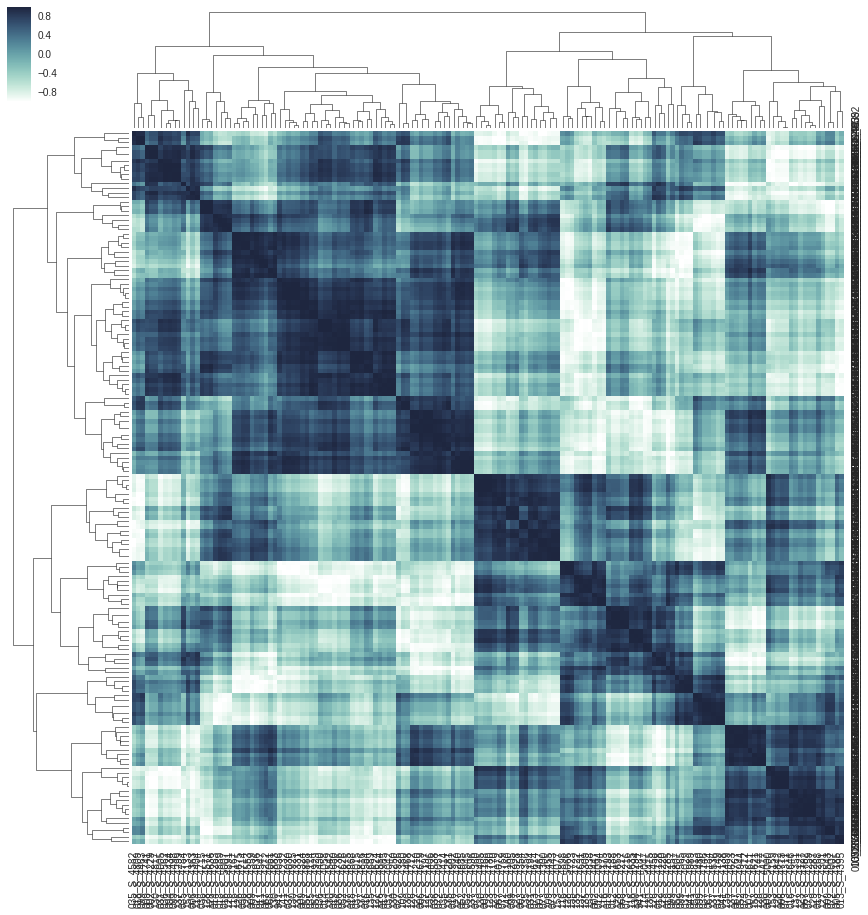

In [8]:
#test_merge.to_csv(baseline_dir+'input_csv/Longitduinal_HC_CT_data.csv')

# print  np.sum(test_merge['2PointLoss'].values)/269.0
# traj = test_merge['APOE4'].values + test_merge['2PointLoss'].values
# for i in range(4):
#     print np.sum(traj==i)

# Intersubject correlations
from string import letters
sns.set(style="white")

CS_cols = ['ADAS13_bl','ADAS13_m06','ADAS13_m12','ADAS13_m24']
#CS_cols = ['MMSE_bl','MMSE_m06','MMSE_m12','MMSE_m24']

d = pd.DataFrame(data=np.transpose(test_merge[CS_cols].values),
                 index = CS_cols,
                 columns=test_merge['PTID'].values)

# Compute the correlation matrix
corr = d.corr()
corr = corr.fillna(0) #NAN rise from subject with constant scores over all timepoints

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap,
#             square=True, xticklabels=10, yticklabels=10,
#             cbar_kws={"shrink": 1}, ax=ax)

#sns.clustermap(data=corr, annot=True, cmap='Greens')
cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
g = sns.clustermap(corr, method='average', cmap=cmap, figsize=(15, 15))


75 81
(156,) (4, 156)


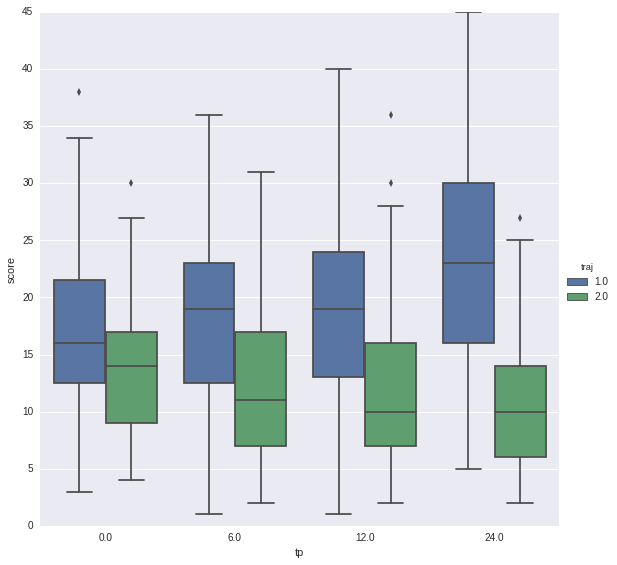

In [403]:
import scipy.cluster.hierarchy as sch
Z = g.dendrogram_col.linkage
T = sch.fcluster(Z, 2, 'maxclust')
print np.sum(T==1),np.sum(T==2)
print T.shape, d.values.shape

tpx, subx = d.values.shape
score_vec = d.transpose().values.reshape(tpx*subx,1)
tp_vec = np.tile([0,6,12,24],subx).reshape(tpx*subx,1)
T_tp = np.repeat(T,4, axis=0).reshape(tpx*subx,1)

df_traj = pd.DataFrame(data = np.hstack((score_vec,tp_vec,T_tp)), columns=['score','tp','traj'])
sns.set_style("darkgrid")
ax = sns.factorplot(x="tp", y='score', hue='traj', kind='box', data=df_traj,size=8)

In [11]:
#d.to_csv(baseline_dir+'input_csv/Longitduinal_MCI_ADAS13_traj.csv')
print baseline_dir

/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/


univar: AGE, t_val:0.769, p_val:0.443
univar: ADAS13_bl, t_val:2.998, p_val:0.003
    agg_filter = None
    alpha = None
    animated = False
    axes = Axes(0.257857,0.853313;0.110714x0.0466867)
    bbox_patch = None
    children = []
    clip_box = None
    clip_on = True
    clip_path = None
    color = .15
    contains = None
    family or fontfamily or fontname or name = [u'sans-serif']
    figure = Figure(2400x3200)
    fontproperties or font_properties = :family=sans-serif:style=normal:variant=normal:wei...
    gid = None
    horizontalalignment or ha = center
    label = 
    name or fontname = Liberation Sans
    path_effects = []
    picker = None
    position = (0.5, 1.0)
    prop_tup = (0.5, 1.0, u't_val:2.998, p_val:0.003', '.15', u'b...
    rasterized = None
    rotation = 0.0
    rotation_mode = None
    size or fontsize = 10.0
    sketch_params = None
    snap = None
    stretch or fontstretch = normal
    style or fontstyle = normal
    text = t_val:2.998, p_val:0.003


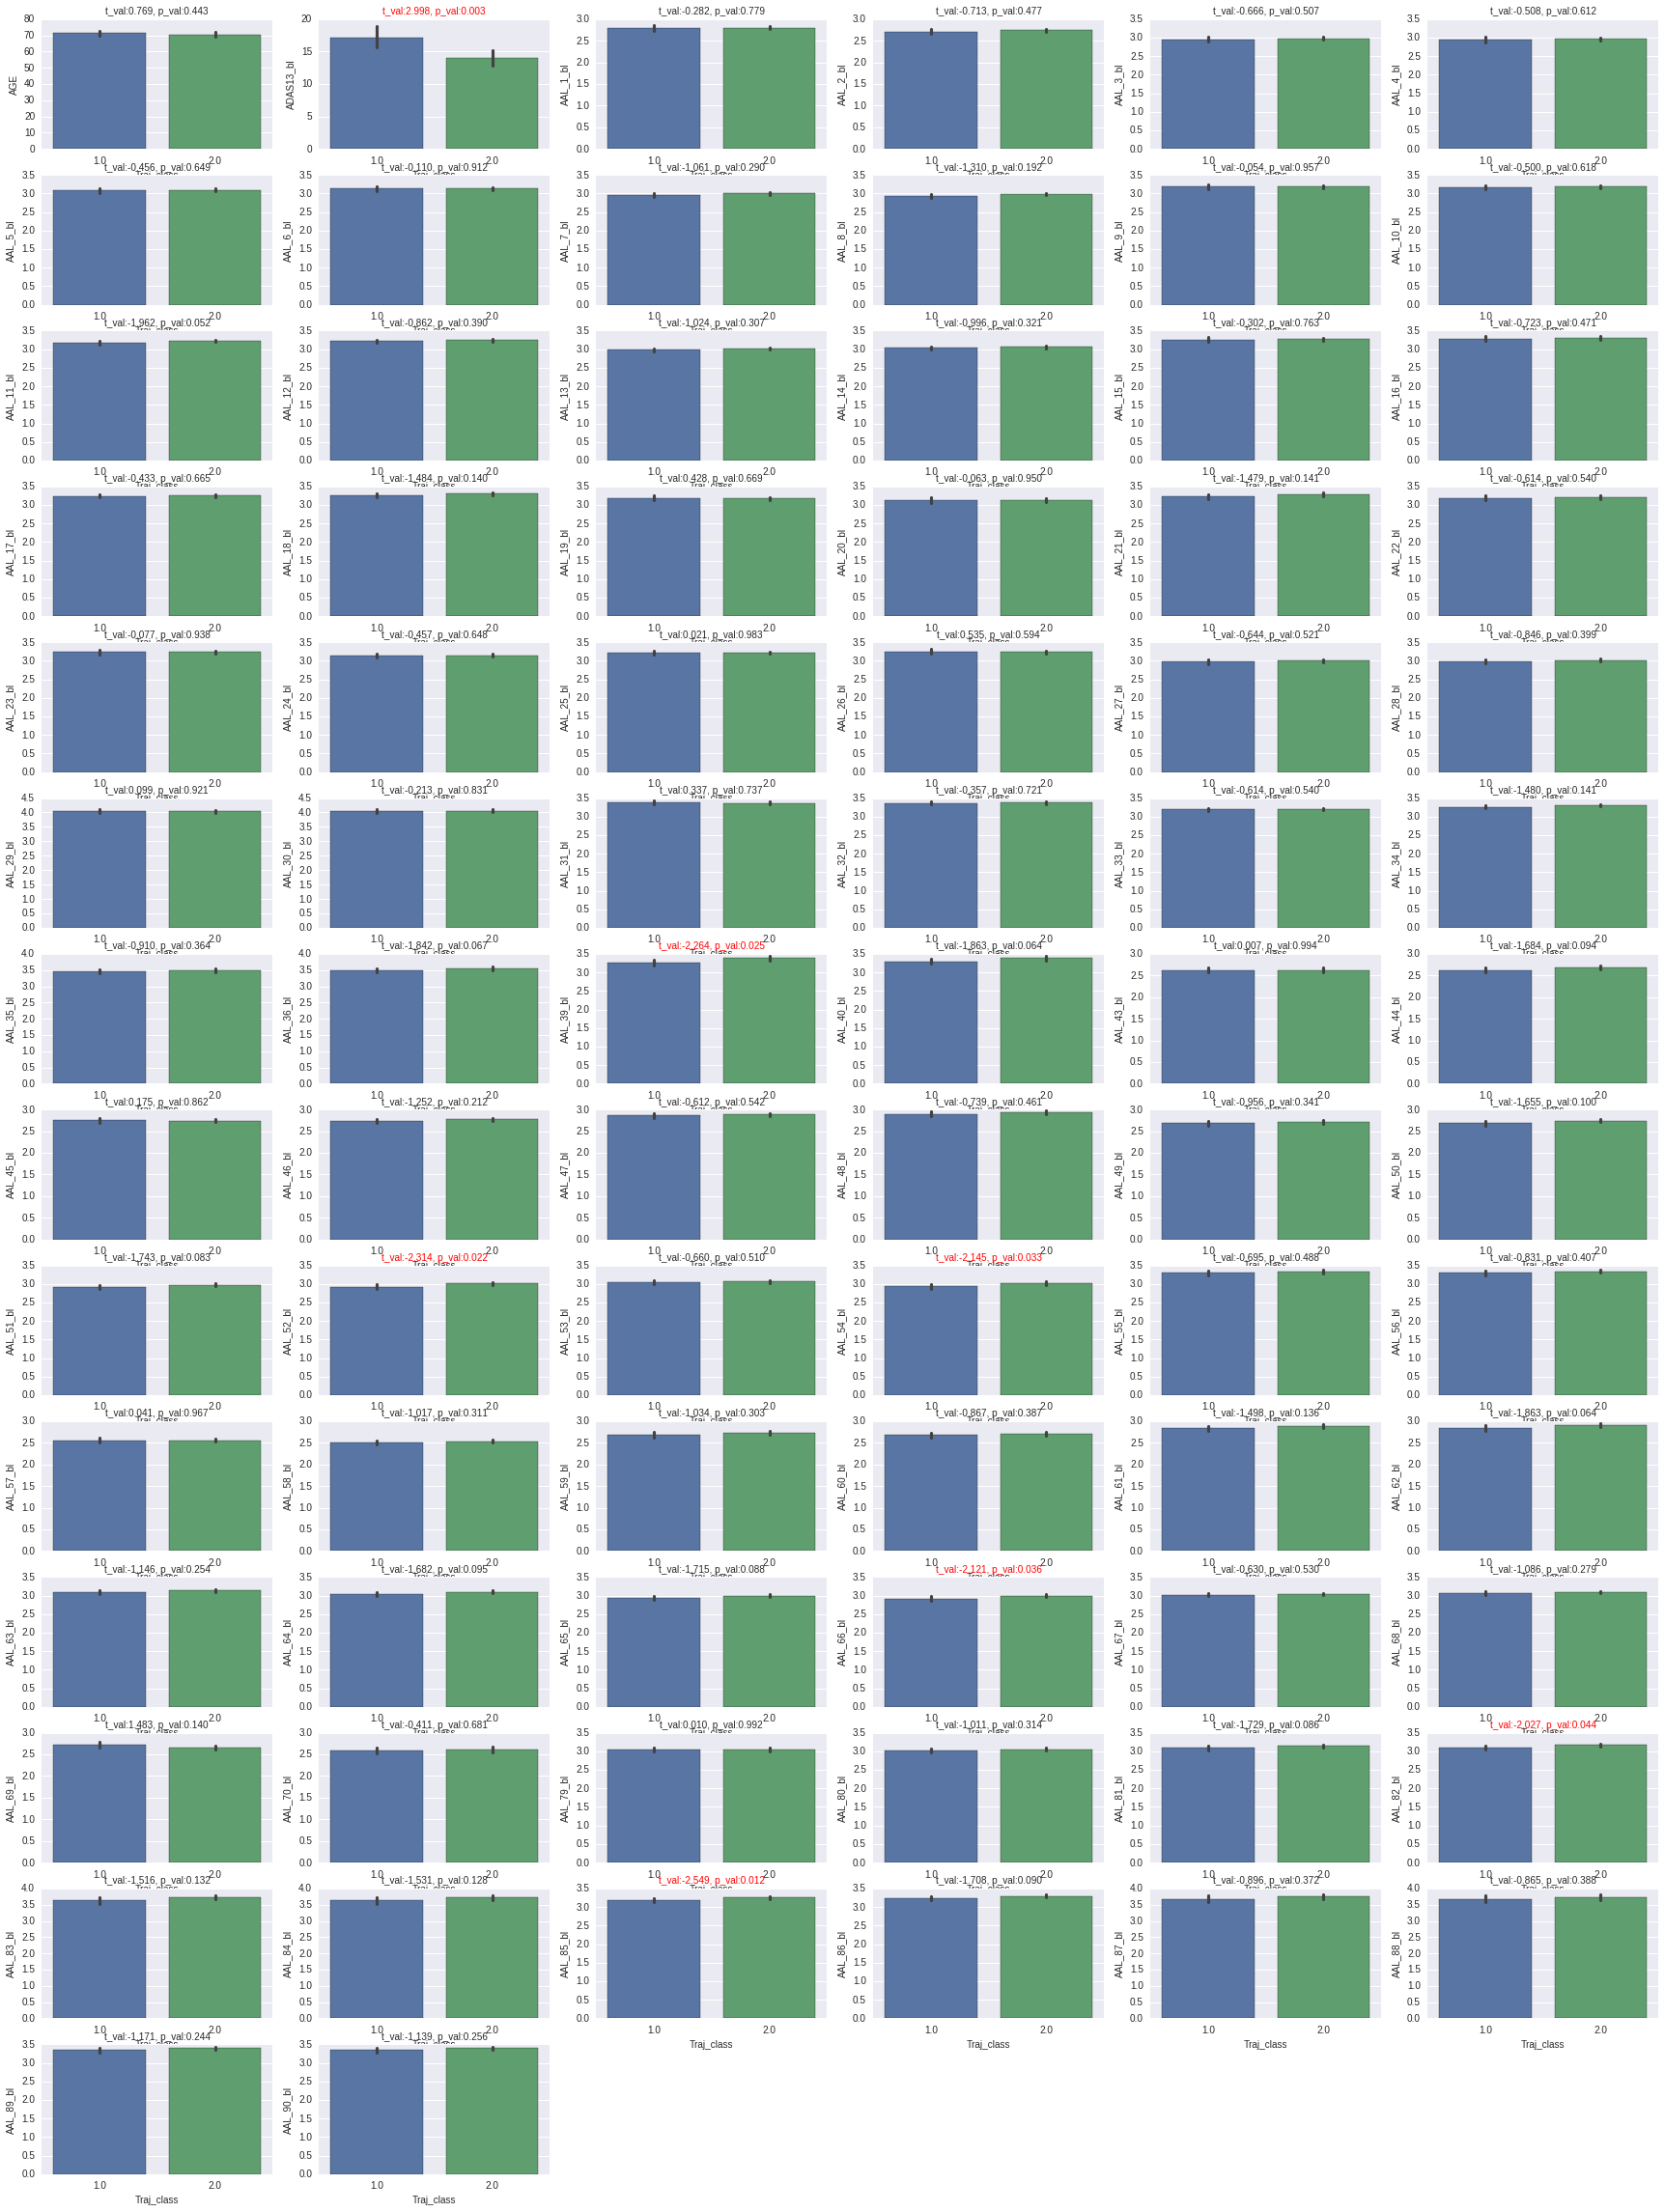

In [405]:
plt.rcParams['figure.figsize'] = (30, 40)
font_size = 10
from scipy.stats import ttest_ind

univar_measures = ['AGE','ADAS13_bl'] 
for feat in ct_feat:
    univar_measures.append(feat + '_bl')
    
cols = 6
rows = np.ceil(float(len(univar_measures))/cols)

for u, univar in enumerate(univar_measures):
    if univar in ['APOE4','PTGENDER']:
        univar_measure_cat = np.transpose(test_merge[univar].values)
    else:
        univar_measure_cat = np.transpose(test_merge[univar].values)
        
    dx_traj = np.transpose(np.vstack((univar_measure_cat, T)))
    dx_traj_df = pd.DataFrame(data=dx_traj, columns=[univar,'Traj'])
    
    
    if univar not in ['APOE4','PTGENDER']:
        cat1 = test_merge[univar].values[T==1]
        cat2 = test_merge[univar].values[T==2]

        print 'univar: {}, t_val:{:4.3f}, p_val:{:4.3f}'.format(univar, ttest_ind(cat1,cat2)[0],ttest_ind(cat1,cat2)[1])

        
    plt.subplot(rows,cols,u+1)
    sns.barplot(y=univar, x='Traj', data=dx_traj_df)
    title_obj = plt.title('t_val:{:4.3f}, p_val:{:4.3f}'.format(ttest_ind(cat1,cat2)[0],ttest_ind(cat1,cat2)[1]),fontsize=font_size)
    if ttest_ind(cat1,cat2)[1] < 0.05:        
        plt.getp(title_obj)                    #print out the properties of title
        plt.getp(title_obj, 'text')            #print out the 'text' property for title
        plt.setp(title_obj, color='r')         #set the color of title to red
        
    plt.ylabel(univar, fontsize=font_size)
    plt.xlabel('Traj_class', fontsize=font_size)
    

In [342]:
# # Save test_merge
# test_merge['Traj'] = T-1
# test_merge.to_csv(baseline_dir+'input_csv/Longitduinal_HC_CT_data_MCI_traj.csv')
# print T.shape, d.values.shape
# print np.min(d.values[3][T==1]), np.max(d.values[3][T==1])
# print np.min(d.values[3][T==2]), np.max(d.values[3][T==2])

dx_traj_df_stack

,univar_val,univar_key,Traj
0,66.4,AGE,1
1,67.5,AGE,2
2,75.7,AGE,2
3,82.2,AGE,2
4,80.4,AGE,2
5,73.5,AGE,1
6,69.1,AGE,1
7,70.5,AGE,2
8,61.9,AGE,2
9,66.9,AGE,2


In [ ]:
# plotting stats
plt.rcParams['figure.figsize'] = (15, 20)
font_small = 8
font_med = 16
font_large = 24
# pick variable(s) i.e. columns and rows with no NaN values 
clinical_var = col_list_feat
time_points = ['_m06','_m12','_m24']
subplot_idx = 0
for row, c_var in enumerate(clinical_var):
    if not c_var in ['PTID','DX']:
        for col, time_point in enumerate(time_points):
            subplot_idx += 1
            plt.subplot(len(clinical_var), len(time_points), subplot_idx)
            x = test_merge[c_var + time_point] - test_merge[c_var + '_bl']
            print 'total number of subjects: {}'.format(len(x.values))
            x = x[np.isfinite(x)]
            print 'total number of subjects without NaNs: {}'.format(len(x.values))
            sns.distplot(x, kde=False, rug=True)
            plt.xlabel('{} - score_bl'.format(c_var + time_point), fontsize=font_med)
            title_str = 'N={}, mean: {:3.2f}, std: {:3.2f}'.format(len(x.values), np.mean(x),np.std(x))
            plt.title(title_str)

In [ ]:
# Draw a stratified Cognititive decline plot per Dx
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
clinical_var = col_list_feat
time_points = ['_m06','_m12','_m24']
i=0
for c_var in clinical_var:
    if not c_var in ['PTID','DX','DX_cat']:
        for tp in time_points:
            i+=1
            col = c_var + tp + '_diff'
            #plt.subplot(2,3,i)
            g = sns.factorplot(x="DX_cat_bl", y=col, data=test_merge, size=6, kind="bar", palette="muted")
            #g.despine(left=True)
            g.set_ylabels(col, fontsize = font_large)

            print 'population mean: {}, std: {}'.format(np.mean(test_merge[col]),np.std(test_merge[col]))

In [248]:
clinical_var = ['ADAS13','MMSE','DX_cat']
for i, c_var in enumerate(clinical_var):
    traj = [test_merge[c_var + '_bl'], test_merge[c_var + '_m06'], 
            test_merge[c_var + '_m12'], test_merge[c_var + '_m24']]
    traj = np.array(traj)
    t = test_merge['AGE']
    t = np.vstack((t,t+0.5,t+1,t+2))
    plt.subplot(3,1,i+1)
    for j in np.arange(t.shape[1]):        
        plt.plot(t[:,j],traj[:,j],'.-')
    plt.xlabel('AGE')
    plt.ylabel(c_var)
    
    

SyntaxError: invalid syntax (<ipython-input-248-f71b1e5ad083>, line 5)

In [606]:
from sklearn.preprocessing import scale
dim_reduct = 'both'

mr_feat = []
cl_feat = [] 
for f in hc_feat:
    mr_feat.append(test_merge[f+'_bl'].values)
    #mr_feat.append(test_merge[f+'_m24_diff'].values)


mr_feat = np.transpose(np.array(mr_feat))
print 'mr_feat_shape: {}'.format(mr_feat.shape)

cl_feat.append(test_merge['ADAS13_bl'].values)
#cl_feat.append(test_merge['ADAS13_m24_diff'].values)

#cl_feat.append(test_merge['AGE'].values)
#l_feat.append(test_merge['APOE4'].values)
#cl_feat.append(test_merge['DX_cat_bl'].values)
#cl_feat.append(test_merge['ADAS13_m24_diff'].values) 

cl_feat = np.transpose(np.array(cl_feat))
print 'cl_feat_shape: {}'.format(cl_feat.shape)

feat = np.hstack((mr_feat,cl_feat))
print 'feat_shape: {}'.format(feat.shape)
filtered_idx = ~np.isnan(feat).any(axis=1)
feat = feat[filtered_idx]
print 'feat_shape: {}'.format(feat.shape)
print np.mean(feat), np.std(feat)
feat = scale(feat)
print np.mean(feat), np.std(feat)

feat_X = feat[:,:feat.shape[1]-1]
print feat_X.shape

mr_feat_shape: (295, 18)
cl_feat_shape: (295, 1)
feat_shape: (295, 19)
feat_shape: (295, 19)
361.406015182 251.455931432
3.11852833179e-16 1.0
(295, 18)


[ 0.5569602   0.09177786  0.07195125  0.0679758   0.05673586  0.03367637
  0.02452314  0.01772133  0.01452623  0.01200715]


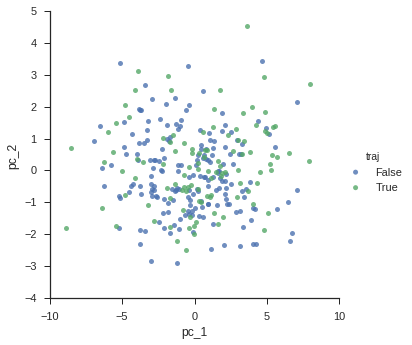

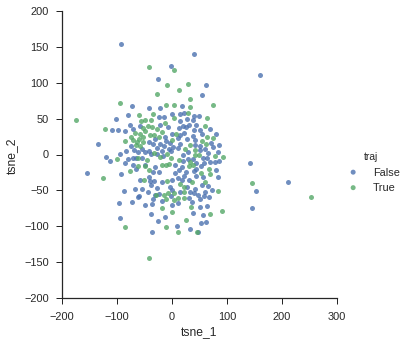

In [607]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

traj = test_merge['PointMod4'].values[filtered_idx]

if dim_reduct == 'pca':
    model = PCA(n_components=10)
    embeddings = model.fit_transform(feat_X) 
    print model.explained_variance_ratio_
    df = pd.DataFrame({'pc_1':embeddings[:,0],'pc_2':embeddings[:,1], 'traj':traj})
    sns.lmplot('pc_1', 'pc_2', data=df, fit_reg=False,hue="traj", scatter_kws={"marker": "D", "s": 25}, size=8)
elif dim_reduct == 'tsne':
    model = TSNE(n_components=2, random_state=0, init='pca')
    embeddings = model.fit_transform(feat_X) 
    df = pd.DataFrame({'tsne_1':embeddings[:,0],'tsne_2':embeddings[:,1], 'traj':traj})
    sns.lmplot('tsne_1', 'tsne_2', data=df, fit_reg=False,hue="traj", scatter_kws={"marker": "D", "s": 25}, size=8)
elif dim_reduct == 'both':
    model = PCA(n_components=10)
    pca_embeddings = model.fit_transform(feat_X) 
    print model.explained_variance_ratio_    
    model = TSNE(n_components=2, random_state=0, init='pca')
    tsne_embeddings = model.fit_transform(feat_X) 
    df = pd.DataFrame({'pc_1':pca_embeddings[:,0],'pc_2':pca_embeddings[:,1], 
                       'tsne_1':tsne_embeddings[:,0],'tsne_2':tsne_embeddings[:,1], 'traj':traj})
    sns.lmplot('pc_1', 'pc_2', data=df, fit_reg=False,hue="traj", scatter_kws={"marker": "D", "s": 25}, size=5)
    sns.lmplot('tsne_1', 'tsne_2', data=df, fit_reg=False,hue="traj", scatter_kws={"marker": "D", "s": 25}, size=5)
else:
    print 'unknown dim_reduct technique'


In [513]:
np.median(test_merge['ADAS13_m24_diff'].values[filtered_idx])


0.0

In [ ]:
clinical_var = ['MMSE','ADAS13']
time_points = ['_m06','_m12','_m24']

for c_var in clinical_var:
    for tp in time_points:
        g = sns.PairGrid(test_merge, y_vars=c_var + tp + "_diff",
                         x_vars=["AGE_median_split","PTGENDER", "APOE4", 'DX_cat_bl'],
                         size=5, aspect=.5)

        # Draw a seaborn pointplot onto each Axes
        g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])    
        if c_var =='MMSE':
            g.set(ylim=(-6, 0.5))            
        else:
            g.set(ylim=(-4, 14))
        sns.despine(fig=g.fig, left=True)
        

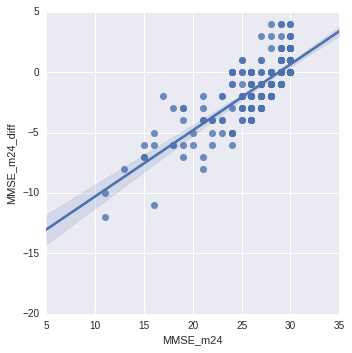

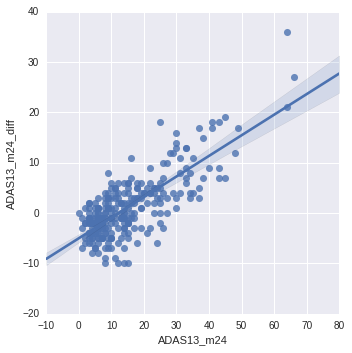

In [40]:
sns.lmplot('MMSE_m24', 'MMSE_m24_diff', 
           data=test_merge, 
           fit_reg=True,            
           scatter_kws={"marker": "D", "s": 50})

sns.lmplot('ADAS13_m24', 'ADAS13_m24_diff', 
           data=test_merge, 
           fit_reg=True,            
           scatter_kws={"marker": "D", "s": 50})


In [ ]:
# Compute the correlation matrix


# # Select a subset of the networks
# used_networks = [1, 5, 6, 7, 8, 11, 12, 13, 16, 17]
# used_columns = (df.columns.get_level_values("network")
#                           .astype(int)
#                           .isin(used_networks))
# df = df.loc[:, used_columns]

df= test_merge[['AGE', 'APOE4', 'DX_cat_m06_diff', 'DX_cat_m12_diff', 'DX_cat_m24_diff', 
               'ADAS13_m06_diff', 'ADAS13_m12_diff', 'ADAS13_m24_diff', 'MMSE_m06_diff', 'MMSE_m12_diff', 'MMSE_m24_diff', 
               'L_CA1_m06_diff', 'L_CA1_m12_diff', 'L_CA1_m24_diff', 'L_subiculum_m06_diff', 'L_subiculum_m12_diff', 'L_subiculum_m24_diff', 
               'L_CA4DG_m06_diff', 'L_CA4DG_m12_diff', 'L_CA4DG_m24_diff', 'L_CA2CA3_m06_diff', 'L_CA2CA3_m12_diff', 'L_CA2CA3_m24_diff', 
               'L_stratum_m06_diff', 'L_stratum_m12_diff',
               'L_stratum_m24_diff', 'L_Alv_m06_diff', 'L_Alv_m12_diff', 'L_Alv_m24_diff', 'L_Fimb_m06_diff', 'L_Fimb_m12_diff', 'L_Fimb_m24_diff',
               'L_Fornix_m06_diff', 'L_Fornix_m12_diff', 'L_Fornix_m24_diff', 'L_Mam_m06_diff', 'L_Mam_m12_diff', 'L_Mam_m24_diff', 'R_CA1_m06_diff', 
               'R_CA1_m12_diff', 'R_CA1_m24_diff', 'R_subiculum_m06_diff', 'R_subiculum_m12_diff', 'R_subiculum_m24_diff', 'R_CA4DG_m06_diff', 
               'R_CA4DG_m12_diff', 'R_CA4DG_m24_diff', 'R_CA2CA3_m06_diff', 'R_CA2CA3_m12_diff', 'R_CA2CA3_m24_diff', 'R_stratum_m06_diff', 
               'R_stratum_m12_diff', 'R_stratum_m24_diff', 'R_Alv_m06_diff', 'R_Alv_m12_diff', 'R_Alv_m24_diff', 'R_Fimb_m06_diff', 'R_Fimb_m12_diff', 
               'R_Fimb_m24_diff', 'R_Fornix_m06_diff', 'R_Fornix_m12_diff', 'R_Fornix_m24_diff', 'R_Mam_m06_diff', 'R_Mam_m12_diff', 'R_Mam_m24_diff']]

# Create a custom colormap for the heatmap values
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)

# Draw the full plot
cg = sns.clustermap(df.corr(), linewidths=.5, figsize=(13, 13), cmap=cmap)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [9]:
x = test_merge

feat_list = ct_feat #pick one: hc_feat or ct_feat
                
time_points_mr = ['_bl','_m06','_m12','_m24']
#time_points_cs = ['_m12','_m24']
time_points_cs = ['_m24','_m24','_m24','_m24']
corr_dict = {}
idx = 0
feat_grp_size = 9 #Esthetics - number of lines in the same plot. 
for f, feat in enumerate(feat_list):
    for tp_mr, tp_cs in zip(time_points_mr,time_points_cs):
        adas = test_merge['ADAS13'+tp_cs].values
        adas_clean = adas[np.isfinite(adas)]        
        y = test_merge[feat+tp_mr].values
        y = y[np.isfinite(adas)]
        adas_r = stats.pearsonr(y,adas_clean)[0]
        
        mmse = test_merge['MMSE'+tp_cs].values
        mmse_clean = mmse[np.isfinite(mmse)]        
        y = test_merge[feat+tp_mr].values
        y = y[np.isfinite(mmse)]
        mmse_r = stats.pearsonr(y,mmse_clean)[0]
        
        corr_dict[idx]={'structure':feat,'time-point':tp_mr,'adas_r':adas_r,'mmse_r':mmse_r,'feat_grp':f/feat_grp_size}
        idx += 1
    
df = pd.DataFrame.from_dict(corr_dict,orient='index')
    

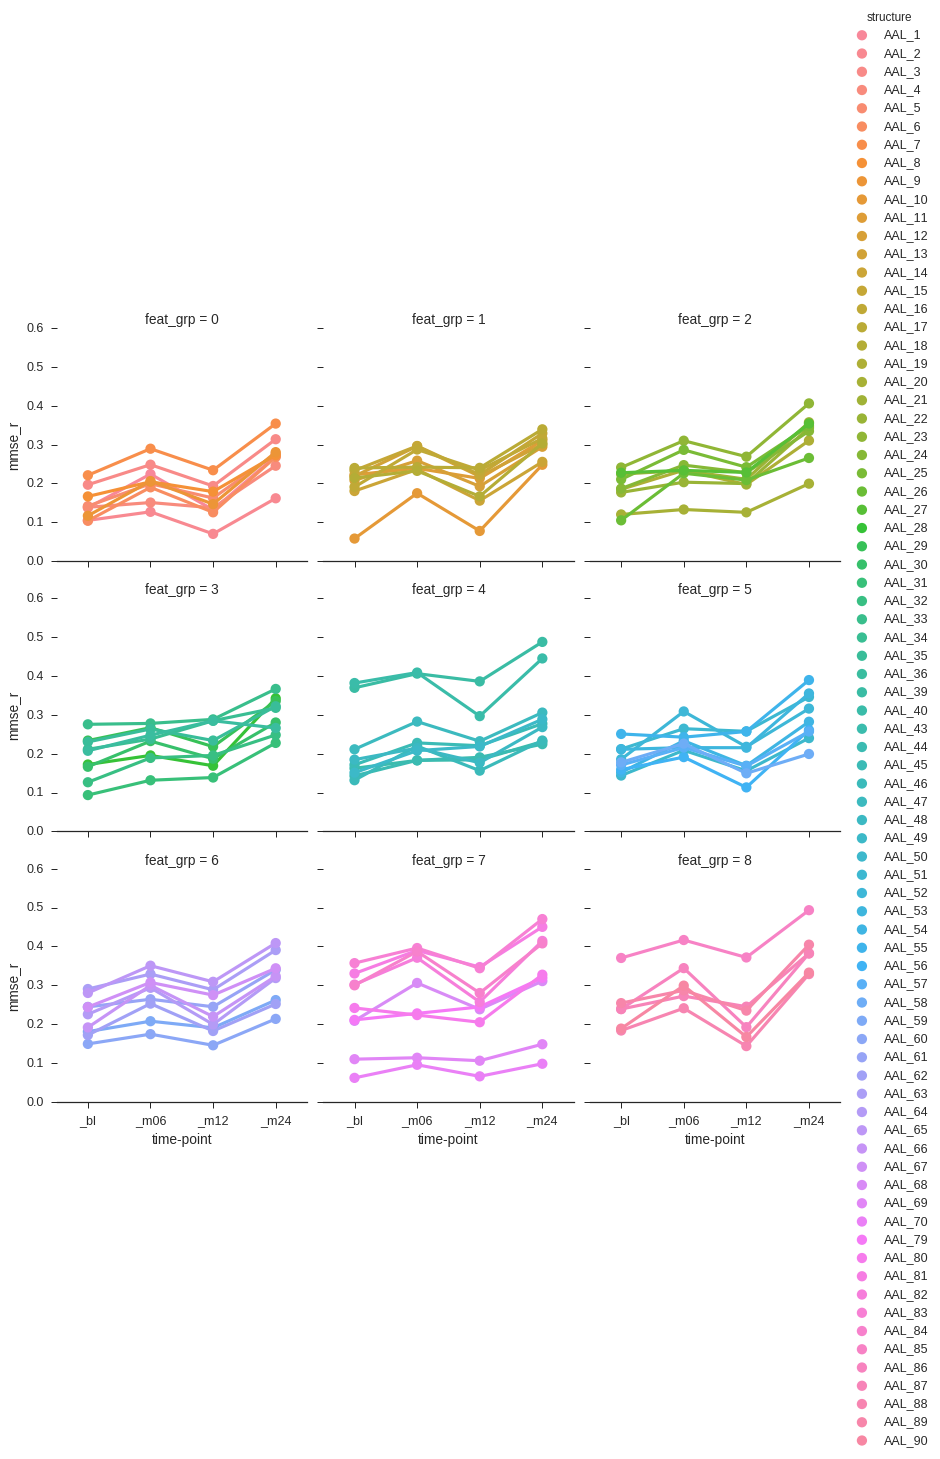

In [46]:
sns.set_context("notebook", font_scale=1.25)
sns.set_style("ticks")
clinical_scale = 'mmse_r'
if len(feat_list) == 18: #hc_feat
    g = sns.factorplot(x="time-point", y=clinical_scale, hue='structure', col='feat_grp', col_wrap=2,
                       markers=['o', 'd', 's','+', '^', '>', 'v', '<','x','o', 'd', 's','+', '^', '>', 'v', '<','x'],
                       data=df, size=5)
else: 
    g = sns.factorplot(x="time-point", y=clinical_scale, hue='structure', col='feat_grp', col_wrap=3, data=df, size=4)
g.despine(left=True)
#plt.title('Correlation between structural measure vs. clinical scores')


In [56]:
a = 10.10101010101
print 'a: {:2.1f}'.format(a)

a: 10.1
